# Booking

This example uses the 'Expedia' dataset to predict, based on site activity, whether a user is likely to make a booking. You can download the Jupyter Notebook of the study <a href="booking.ipynb">here</a> and the the dataset <a href="https://www.kaggle.com/c/expedia-hotel-recommendations/data">here</a>.

<ul class="ul_content">
    <li><b>cnt: </b>Number of similar events in the context of the same user session.</li>
    <li><b>user_location_city: </b>The ID of the city in which the customer is located.</li>
    <li><b>is_package: </b>1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise.</li>
    <li><b>user_id: </b>ID of the user</li>
    <li><b>srch_children_cnt: </b>The number of (extra occupancy) children specified in the hotel room.</li>
    <li><b>channel: </b>marketing ID of a marketing channel.</li>
    <li><b>hotel_cluster: </b>ID of a hotel cluster.</li>
    <li><b>srch_destination_id: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>is_mobile: </b>1 if the user is on a mobile device, 0 otherwise.</li>
    <li><b>srch_adults_cnt: </b>The number of adults specified in the hotel room.</li>
    <li><b>user_location_country: </b>The ID of the country in which the customer is located.</li>
    <li><b>srch_destination_type_id: </b>ID of the destination where the hotel search was performed.</li>
    <li><b>srch_rm_cnt: </b>The number of hotel rooms specified in the search.</li>
    <li><b>posa_continent: </b>ID of the continent associated with the site_name.</li>
    <li><b>srch_ci: </b>Check-in date.</li>
    <li><b>user_location_region: </b>The ID of the region in which the customer is located.</li>
    <li><b>hotel_country: </b>Hotel's country.</li>
    <li><b>srch_co: </b>Check-out date.</li>
    <li><b>is_booking: </b>1 if a booking, 0 if a click.</li>
    <li><b>orig_destination_distance: </b>Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated.</li>
    <li><b>hotel_continent: </b>Hotel continent.</li>
    <li><b>site_name: </b>ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...).</li>
</ul>

We will follow the data science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) to solve this problem.

## Initialization

This example uses the following version of VerticaPy:

In [1]:
import verticapy as vp
vp.__version__

'0.9.0'

Connect to Vertica. This example uses an existing connection called "VerticaDSN." For details on how to create a connection, use see the <a href="../../connection.php">connection tutorial</a>.

In [2]:
vp.connect("VerticaDSN")

Let's create a Virtual DataFrame of the dataset.

,📅date_timeTimestamp,123site_nameInt,123posa_continentInt,123user_location_countryInt,123user_location_regionInt,123user_location_cityInt,"123orig_destination_distanceNumeric(11,5)",123user_idInt,123is_mobileInt,123is_packageInt,123channelInt,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInt,123srch_children_cntInt,123srch_rm_cntInt,123srch_destination_idInt,123srch_destination_type_idInt,123is_bookingInt,123cntInt,123hotel_continentInt,123hotel_countryInt,123hotel_marketInt,123hotel_clusterInt
1,2013-01-07 00:00:02,24,2,3,50,5703,[null],461899,0,0,9,2013-03-14,2013-03-15,2,1,1,669,3,0,1,2,50,212,41
2,2013-01-07 00:00:06,2,3,66,174,21177,5713.6206,13796,0,0,9,2013-01-19,2013-01-26,1,0,1,8821,1,0,3,6,17,30,58
3,2013-01-07 00:00:06,11,3,205,155,14703,795.7298,1128575,0,0,9,2013-01-19,2013-01-22,1,0,1,25064,6,0,1,2,50,1230,91
4,2013-01-07 00:00:09,37,1,69,761,41949,[null],1080476,0,1,9,2013-05-29,2013-06-05,2,0,1,7635,3,0,1,2,50,675,10
5,2013-01-07 00:00:17,37,1,69,761,41949,[null],1018895,0,0,0,2013-09-08,2013-09-10,2,0,1,27215,6,0,2,2,50,645,59

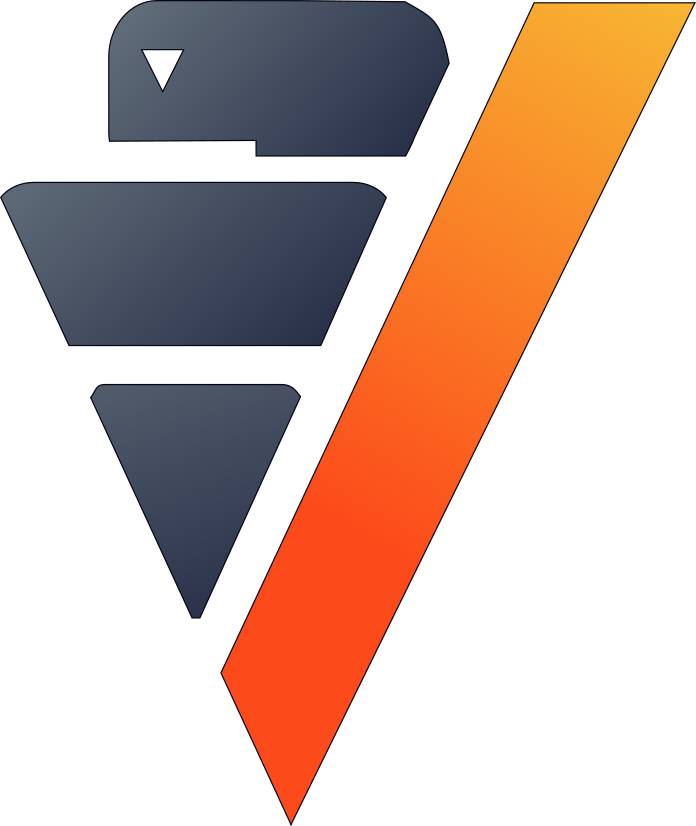

In [3]:
expedia = vp.read_csv('data/expedia.csv', parse_nrows=1000)
expedia.head(5)

## Data Exploration and Preparation

Sessionization is the process of gathering clicks for a certain period of time. We usually consider that after 30 minutes of inactivity, the user session ends (date_time - lag(date_time) > 30 minutes). For these kinds of use cases, aggregating sessions with meaningful statistics is the key for making accurate predictions.

We start by using the sessionize' method to create the variable 'session_id. We can then use this variable to aggregate the data.

,📅date_timeTimestamp,123site_nameInt,123posa_continentInt,123user_location_countryInt,123user_location_regionInt,123user_location_cityInt,"123orig_destination_distanceNumeric(11,5)",123user_idInt,123is_mobileInt,123is_packageInt,123channelInt,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInt,123srch_children_cntInt,123srch_rm_cntInt,123srch_destination_idInt,123srch_destination_type_idInt,123is_bookingInt,123cntInt,123hotel_continentInt,123hotel_countryInt,123hotel_marketInt,123hotel_clusterInt,123session_idInteger
1,2014-09-03 08:18:41,2,3,66,174,9045,53.6059,0,1,0,2,2014-09-06,2014-09-07,2,2,1,24693,6,0,1,2,50,1241,19,0
2,2014-12-03 11:28:11,2,3,66,174,42538,343.7866,0,1,0,2,2014-12-29,2014-12-30,2,1,1,8279,1,0,1,2,50,1230,98,1
3,2014-12-03 11:28:58,2,3,66,174,42538,343.9901,0,1,0,2,2014-12-29,2014-12-30,2,1,1,8279,1,0,1,2,50,1230,40,1
4,2014-12-03 11:30:21,2,3,66,174,42538,343.7968,0,1,0,2,2014-12-29,2014-12-30,2,1,1,8279,1,0,1,2,50,1230,56,1
5,2014-12-03 11:32:43,2,3,66,174,42538,342.2163,0,1,0,2,2014-12-29,2014-12-30,3,2,1,8279,1,0,2,2,50,358,72,1
6,2014-12-06 01:38:26,2,3,66,174,9045,88.1489,0,1,0,2,2014-12-19,2014-12-20,2,2,1,8279,1,0,1,2,50,358,28,2
7,2014-04-25 16:14:28,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,3,1,1,62881,4,0,1,4,98,2052,20,0
8,2014-04-25 16:14:46,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,5,1,2,62881,4,0,1,4,98,2052,20,0
9,2014-04-25 16:15:11,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,3,1,2,62881,4,0,1,4,98,2052,20,0
10,2014-04-25 16:15:50,2,3,66,174,37449,5405.7409,1,1,0,2,2014-11-07,2014-11-09,3,1,2,62881,4,0,1,4,98,2052,60,0

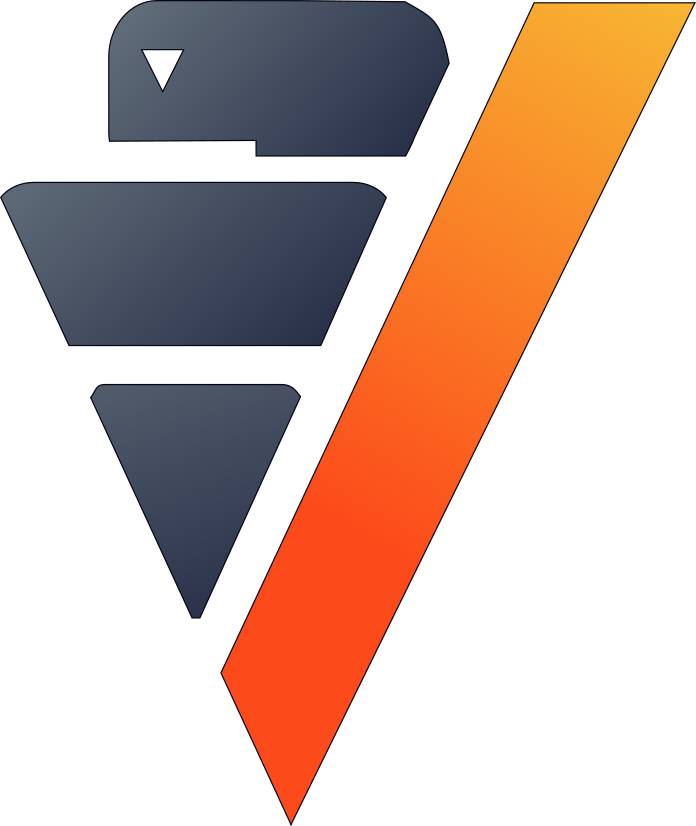

In [4]:
expedia.sessionize(ts = "date_time", 
                   by = ["user_id"], 
                   session_threshold = "30 minutes", 
                   name = "session_id")

The duration of the trip should also influence/be indicative of the user's behavior on the site, so we'll take that into account.

In [5]:
expedia["trip_duration"] = expedia["srch_co"] - expedia["srch_ci"]

If a user looks at the same hotel several times, then it might mean that they're looking to book that hotel during the session.

,📅date_timeTimestamp,123site_nameInt,123posa_continentInt,123user_location_countryInt,123user_location_regionInt,123user_location_cityInt,"123orig_destination_distanceNumeric(11,5)",123user_idInt,123is_mobileInt,123is_packageInt,123channelInt,📅srch_ciDate,📅srch_coDate,123srch_adults_cntInt,123srch_children_cntInt,123srch_rm_cntInt,123srch_destination_idInt,123srch_destination_type_idInt,123is_bookingInt,123cntInt,123hotel_continentInt,123hotel_countryInt,123hotel_marketInt,123hotel_clusterInt,123session_idInteger,123trip_durationInteger,123mode_hotel_clusterInteger,123mode_hotel_cluster_countInteger
1,2014-09-03 08:18:41,2,3,66,174,9045,53.6059,0,1,0,2,2014-09-06,2014-09-07,2,2,1,24693,6,0,1,2,50,1241,19,0,1,19,1
2,2014-12-03 11:32:43,2,3,66,174,42538,342.2163,0,1,0,2,2014-12-29,2014-12-30,3,2,1,8279,1,0,2,2,50,358,72,1,1,72,1
3,2014-12-03 11:30:21,2,3,66,174,42538,343.7968,0,1,0,2,2014-12-29,2014-12-30,2,1,1,8279,1,0,1,2,50,1230,56,1,1,72,1
4,2014-12-03 11:28:58,2,3,66,174,42538,343.9901,0,1,0,2,2014-12-29,2014-12-30,2,1,1,8279,1,0,1,2,50,1230,40,1,1,72,1
5,2014-12-03 11:28:11,2,3,66,174,42538,343.7866,0,1,0,2,2014-12-29,2014-12-30,2,1,1,8279,1,0,1,2,50,1230,98,1,1,72,1
6,2014-12-06 01:38:26,2,3,66,174,9045,88.1489,0,1,0,2,2014-12-19,2014-12-20,2,2,1,8279,1,0,1,2,50,358,28,2,1,28,1
7,2014-04-25 16:14:46,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,5,1,2,62881,4,0,1,4,98,2052,20,0,2,20,3
8,2014-04-25 16:15:11,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,3,1,2,62881,4,0,1,4,98,2052,20,0,2,20,3
9,2014-04-25 16:15:50,2,3,66,174,37449,5405.7409,1,1,0,2,2014-11-07,2014-11-09,3,1,2,62881,4,0,1,4,98,2052,60,0,2,20,3
10,2014-04-25 16:14:28,2,3,66,174,37449,5405.4889,1,1,0,2,2014-11-07,2014-11-09,3,1,1,62881,4,0,1,4,98,2052,20,0,2,20,3

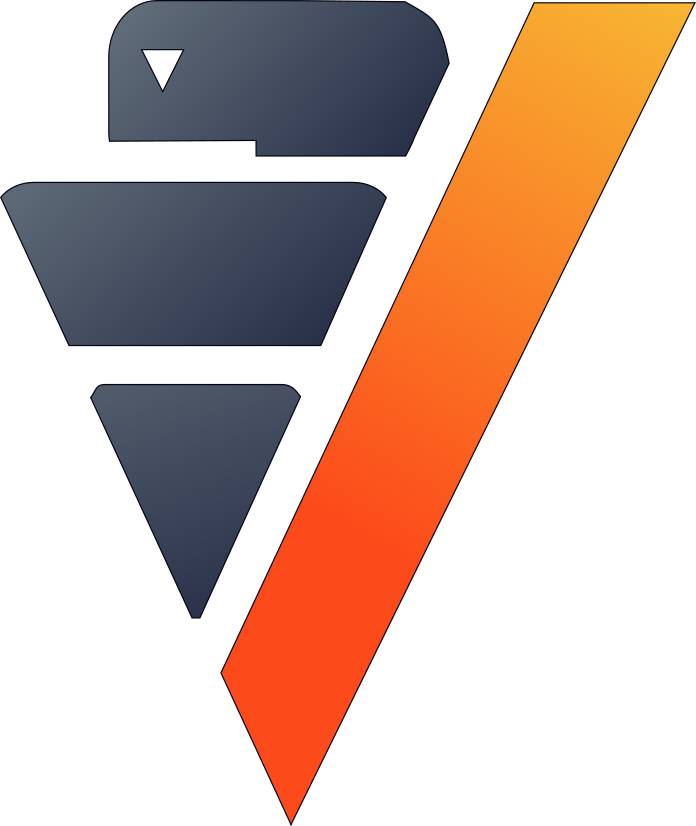

In [6]:
expedia.analytic('mode', 
                 columns = "hotel_cluster", 
                 by = ["user_id",
                       "session_id"], 
                 name = "mode_hotel_cluster",
                 add_count = True)

We can now aggregate the session and get some useful statistics out of it:
<ul class="ul_content">
    <li><b>end_session_date_time :</b> Date and time when the session ends.</li>
    <li><b>session_duration :</b> Session duration.</li>
    <li><b>is_booking :</b> 1 if the user booked during the session, 0 otherwise.</li>
    <li><b>trip_duration :</b> Trip duration.</li>
    <li><b>orig_destination_distance :</b> Average of the physical distances between the hotels and the customer.</li>
    <li><b>srch_family_cnt :</b> The number of people specified in the hotel room.</li>
</ul>

In [7]:
import verticapy.stats as st
expedia = expedia.groupby(
      columns = ["user_id",
                 "session_id", 
                 "mode_hotel_cluster_count"], 
      expr = [st.max(expedia["date_time"])._as("end_session_date_time"),
              ((st.max(expedia["date_time"]) - st.min(expedia["date_time"])) / st.interval("1 second"))._as(
                  "session_duration"),
              st.max(expedia["is_booking"])._as("is_booking"),
              st.avg(expedia["trip_duration"])._as("trip_duration"),
              st.avg(expedia["orig_destination_distance"])._as("avg_distance"),
              st.sum(expedia["cnt"])._as("nb_click_session"),
              st.median(expedia["srch_children_cnt"] + expedia["srch_adults_cnt"])._as("srch_family_cnt")])

Let's look at the missing values.

,count,percent
"""user_id""",12242331.0,100.0
"""session_id""",12242331.0,100.0
"""mode_hotel_cluster_count""",12242331.0,100.0
"""end_session_date_time""",12242331.0,100.0
"""session_duration""",12242331.0,100.0
"""is_booking""",12242331.0,100.0
"""nb_click_session""",12242331.0,100.0
"""srch_family_cnt""",12242331.0,100.0
"""trip_duration""",12226336.0,99.869
"""avg_distance""",7966565.0,65.074

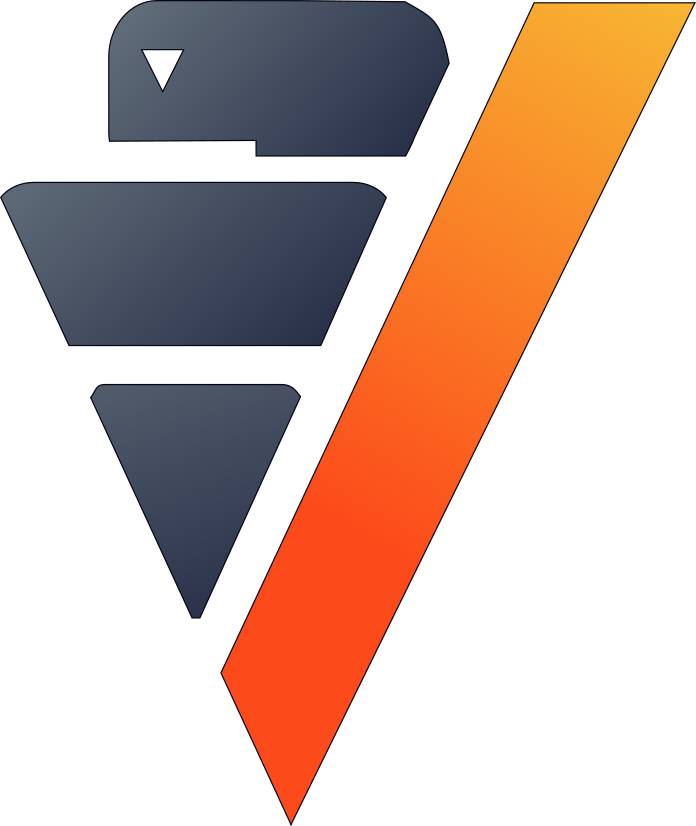

In [8]:
expedia.count_percent()

Let's impute the missing values for avg_distance and trip_duration.

4275766 elements were filled.
15995 elements were filled.


,123user_idInteger100%,123session_idInteger100%,123mode_hotel_cluster_countInteger100%,📅end_session_date_timeDatetime100%,123session_durationFloat100%,123is_bookingInteger100%,123trip_durationFloat100%,123avg_distanceFloat100%,123nb_click_sessionInteger100%,123srch_family_cntFloat100%
1,0,0,1,2014-09-03 08:18:41,0.0,0,1.0,53.6059,1,4.0
2,0,1,1,2014-12-03 11:32:43,272.0,0,1.0,343.44745,5,3.0
3,0,2,1,2014-12-06 01:38:26,0.0,0,1.0,88.1489,1,4.0
4,1,0,3,2014-04-25 16:15:50,82.0,0,2.0,5405.5519,4,4.0
5,2,0,3,2014-01-27 13:54:07,3487.0,0,3.77777777777778,1847.26115380414,13,2.0
6,2,1,2,2014-01-28 12:44:16,1454.0,0,3.0,1847.26115380414,11,2.0
7,2,2,1,2014-01-28 17:11:35,333.0,0,3.0,1847.26115380414,5,2.0
8,3,0,1,2014-07-31 07:10:39,0.0,0,3.0,1432.9656,1,5.0
9,3,1,1,2014-09-08 09:58:50,149.0,0,1.0,141.89605,2,2.0
10,3,2,1,2014-09-09 10:49:48,0.0,0,1.0,143.2998,1,4.0

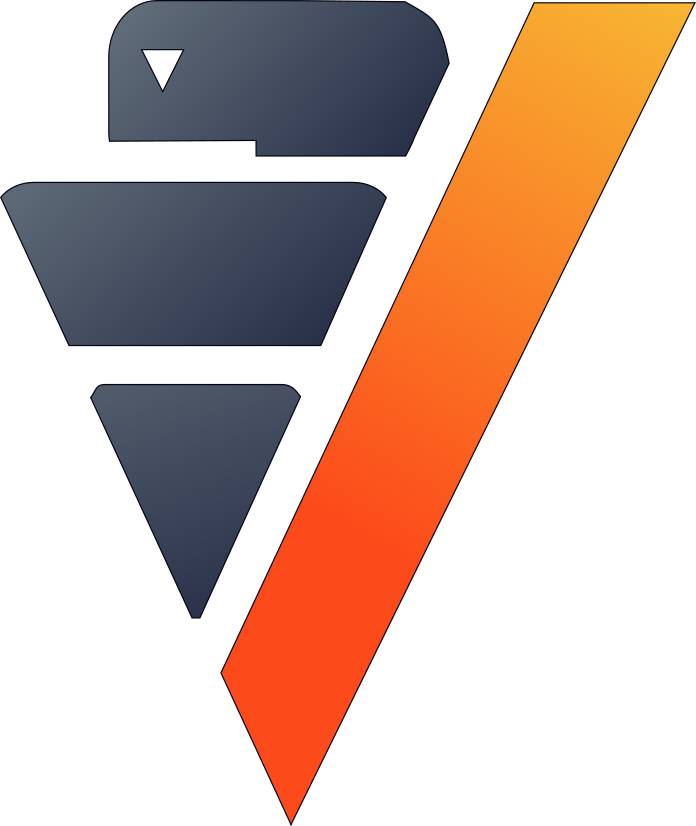

In [9]:
expedia["avg_distance" ].fillna(method = "avg")
expedia["trip_duration"].fillna(method = "avg")

We can then look at the links between the variables. We will use Spearman's rank correleation coefficient to get all the monotonic relationships.

,"""user_id""","""session_id""","""mode_hotel_cluster_count""","""session_duration""","""is_booking""","""trip_duration""","""avg_distance""","""nb_click_session""","""srch_family_cnt"""
"""user_id""",1.0,0.0125372839769691,0.000585488528099556,-0.000541597877304615,0.00168318615437918,-0.00172294332358923,0.00722625140700152,-0.00130288969225954,-0.00145643651427301
"""session_id""",0.0125372839769691,1.0,-0.0362824718948203,-0.0456184717754819,-0.0579097807340728,0.0206225348881192,0.0424225822484464,-0.0614509659970033,-0.0267334768989548
"""mode_hotel_cluster_count""",0.000585488528099556,-0.0362824718948203,1.0,0.693149583808771,0.496196271565582,-0.0229387237074547,-0.00118724174477281,0.654237637118915,0.0430835831263844
"""session_duration""",-0.000541597877304615,-0.0456184717754819,0.693149583808771,1.0,0.331866631464122,0.0125253855406324,0.0188542087982699,0.834960977340327,0.0545771115310364
"""is_booking""",0.00168318615437918,-0.0579097807340728,0.496196271565582,0.331866631464122,1.0,-0.191911129719119,-0.0660072678069069,0.200140132943157,-0.0646466731033034
"""trip_duration""",-0.00172294332358923,0.0206225348881192,-0.0229387237074547,0.0125253855406324,-0.191911129719119,1.0,0.288326587959107,0.0494004219009955,0.0716986783665811
"""avg_distance""",0.00722625140700152,0.0424225822484464,-0.00118724174477281,0.0188542087982699,-0.0660072678069069,0.288326587959107,1.0,0.0322018254928665,-0.0205418178720803
"""nb_click_session""",-0.00130288969225954,-0.0614509659970033,0.654237637118915,0.834960977340327,0.200140132943157,0.0494004219009955,0.0322018254928665,1.0,0.0753040443807521
"""srch_family_cnt""",-0.00145643651427301,-0.0267334768989548,0.0430835831263844,0.0545771115310364,-0.0646466731033034,0.0716986783665811,-0.0205418178720803,0.0753040443807521,1.0

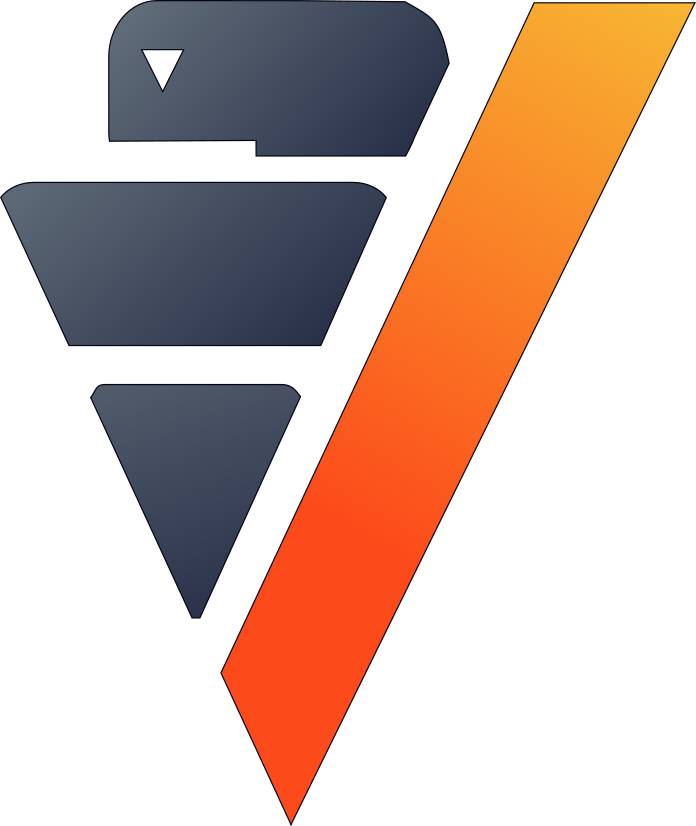

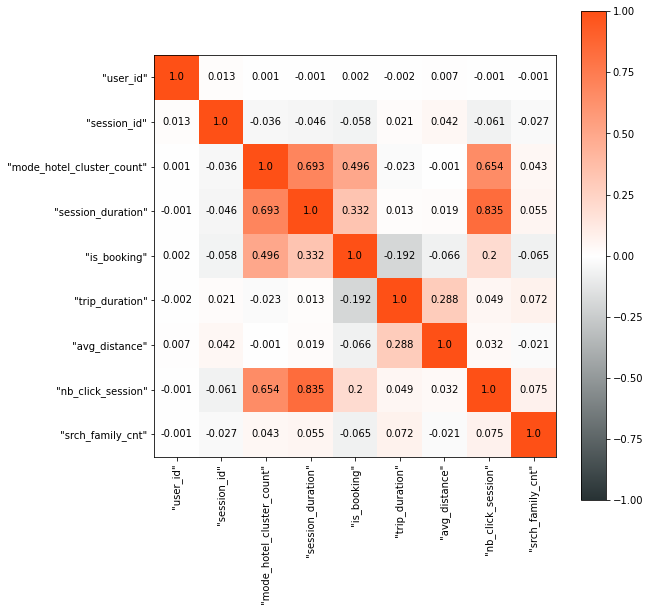

In [10]:
%matplotlib inline
expedia.corr(method = "spearman")

We can see huge links between some of the variables (mode_hotel_cluster_count and session_duration) and our response variable (is_booking). A logistic regression would work well in this case because the response and predictors have a monotonic relationship.

## Machine Learning

Let's create our logistic regression model.

In [11]:
from verticapy.learn.linear_model import LogisticRegression
model_logit = LogisticRegression("expedia_logit", 
                                 max_iter = 1000, 
                                 solver = 'BFGS')
model_logit.fit(expedia, 
                ["avg_distance", 
                 "session_duration",
                 "nb_click_session",
                 "mode_hotel_cluster_count",
                 "session_id",
                 "srch_family_cnt",
                 "trip_duration"], 
                 "is_booking")



details
       predictor        |coefficient|std_err | z_value  |p_value 
------------------------+-----------+--------+----------+--------
       Intercept        | -1.59409  | 0.00275|-579.61668| 0.00000
      avg_distance      | -0.00004  | 0.00000|-81.38289 | 0.00000
    session_duration    |  0.00056  | 0.00000|415.75575 | 0.00000
    nb_click_session    | -0.16990  | 0.00031|-543.77330| 0.00000
mode_hotel_cluster_count|  1.13834  | 0.00125|910.63579 | 0.00000
       session_id       | -0.00583  | 0.00005|-124.80774| 0.00000
    srch_family_cnt     | -0.20765  | 0.00087|-238.93988| 0.00000
     trip_duration      | -0.24810  | 0.00050|-497.93583| 0.00000


regularization
type| lambda 
----+--------
none| 1.00000


call_string
logistic_reg('public.expedia_logit', '"public"."_verticapy_tmp_view_dbadmin_150246_4175658595_"', '"is_booking"', '"avg_distance", "session_duration", "nb_click_session", "mode_hotel_cluster_count", "session_id", "srch_family_cnt", "trip_duration"'
USING PA

None of our coefficients are rejected (pvalue = 0). Let's look at their importance.

,importance,sign
mode_hotel_cluster_count,42.12,1
trip_duration,42.09,-1
nb_click_session,12.1,-1
session_duration,2.64,1
srch_family_cnt,0.65,-1
session_id,0.31,-1
avg_distance,0.09,-1

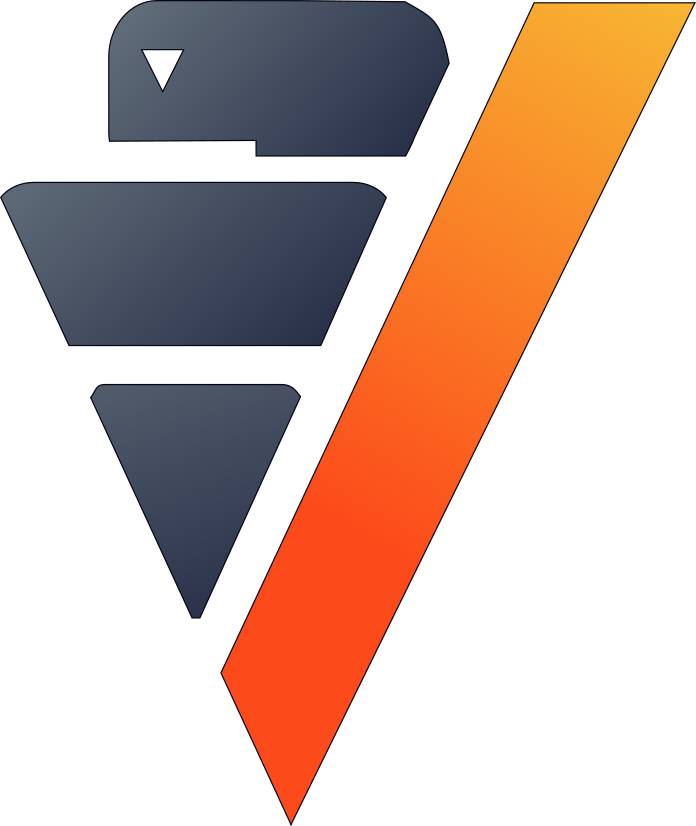

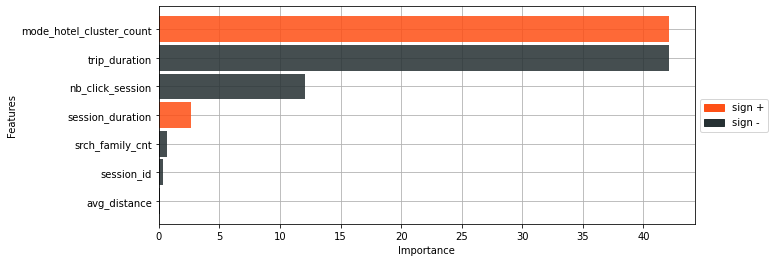

In [12]:
model_logit.features_importance()

It looks like there are two main predictors: mode_hotel_cluster_count and trip_duration. According to our model, users likely to make a booking during a particular session will tend to:

<ul class="ul_content">
    <li>look at the same hotel many times</li>
    <li>look for a shorter trip duration</li>
    <li>not click as much (spend more time at the same web page).</li>
</ul>

Let's add our prediction to the vDataFrame.

,123user_idInteger,123session_idInteger,123mode_hotel_cluster_countInteger,📅end_session_date_timeDatetime,123session_durationFloat,123is_bookingInteger,123trip_durationFloat,123avg_distanceFloat,123nb_click_sessionInteger,123srch_family_cntFloat,123booking_prob_logitFloat
1,0,0,1,2014-09-03 08:18:41,0.0,0,1.0,53.6059,1,4.0,0.153605784760313
2,0,1,1,2014-12-03 11:32:43,272.0,0,1.0,343.44745,5,3.0,0.114769694559958
3,0,2,1,2014-12-06 01:38:26,0.0,0,1.0,88.1489,1,4.0,0.151909565323304
4,1,0,3,2014-04-25 16:15:50,82.0,0,2.0,5405.5519,4,4.0,0.409667557696363
5,2,0,3,2014-01-27 13:54:07,3487.0,0,3.77777777777778,1847.26115380414,13,2.0,0.537789354058044
6,2,1,2,2014-01-28 12:44:16,1454.0,0,3.0,1847.26115380414,11,2.0,0.166867978942862
7,2,2,1,2014-01-28 17:11:35,333.0,0,3.0,1847.26115380414,5,2.0,0.0858210195354118
8,3,0,1,2014-07-31 07:10:39,0.0,0,3.0,1432.9656,1,5.0,0.0781213517098348
9,3,1,1,2014-09-08 09:58:50,149.0,0,1.0,141.89605,2,2.0,0.199954136104512
10,3,2,1,2014-09-09 10:49:48,0.0,0,1.0,143.2998,1,4.0,0.15161252923937

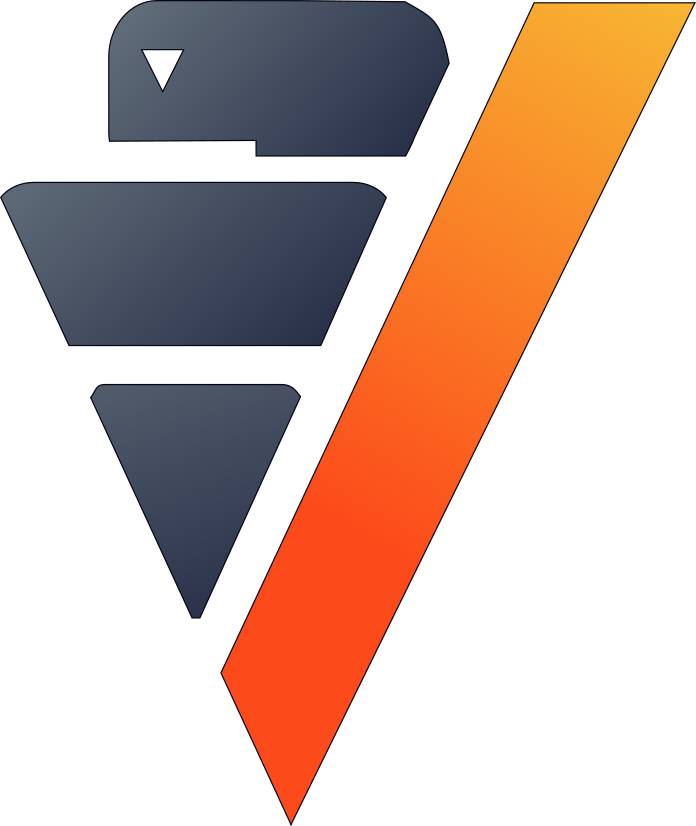

In [13]:
model_logit.predict_proba(expedia, 
                          name = "booking_prob_logit",
                          pos_label = 1)

While analyzing the following boxplot (prediction partitioned by is_booking), we can notice that the cutoff is around 0.22 because most of the positive predictions have a probability between 0.23 and 0.5. Most of the negative predictions are between 0.05 and 0.2.

<AxesSubplot:xlabel='"is_booking"', ylabel='"booking_prob_logit"'>

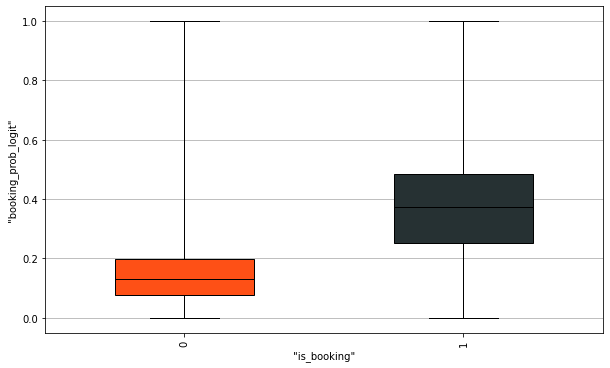

In [14]:
expedia["booking_prob_logit"].boxplot(by = "is_booking")

Let's confirm our hypothesis by computing the best cutoff.

In [15]:
model_logit.score(method = "best_cutoff")

0.2204

Let's look at the efficiency of our model with a cutoff of 0.22.

,value
auc,0.840145448458096
prc_auc,0.5465504635612507
accuracy,0.8021478916065903
log_loss,0.182579215050228
precision,0.5299008517143481
recall,0.7976312038512661
f1_score,0.6367687356440429
mcc,0.5283725198559831
informedness,0.601033970517129
markedness,0.4644954086351514

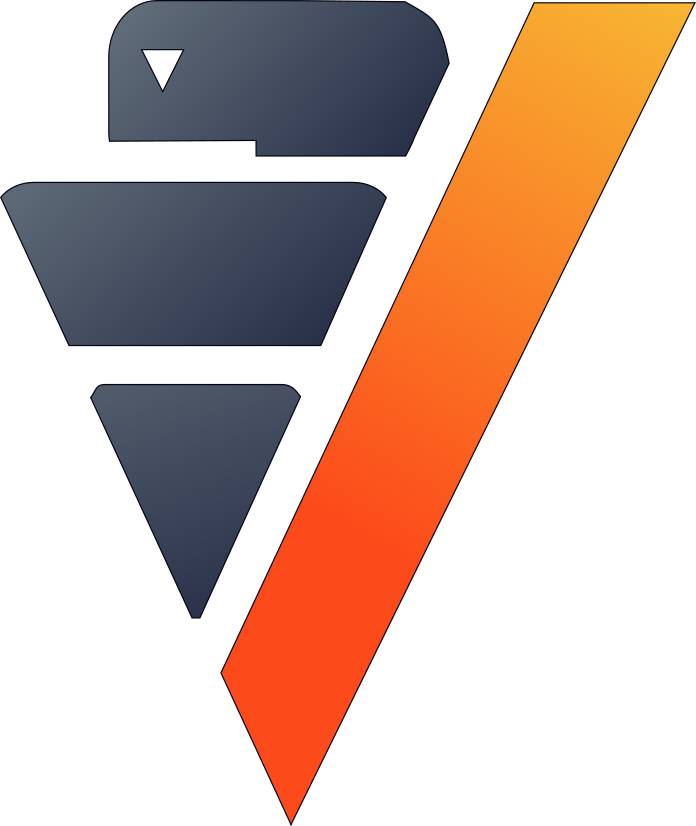

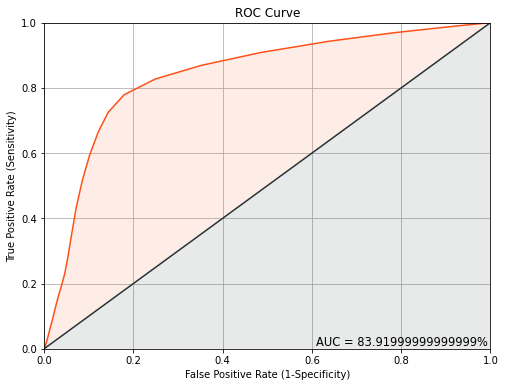

In [16]:
model_logit.roc_curve()
model_logit.report(cutoff = 0.22)

We're left with an excellent model. With this, we can predict whether a user will book a hotel during a specific session and make adjustments to our site accordingly. For example, to influence a user to make a booking, we could propose new hotels.

## Conclusion

We've solved our problem in a Pandas-like way, all without ever loading data into memory!